## EXPLORATORY DATA ANALYSIS (EDA) - FootySage

En primer lugar vamos a importar las librerías que nos van a hacer falta.

In [1]:
import pandas as pd

from statsbombpy import sb
from mplsoccer import Pitch

Ahora cargamos las competiciones, los partidos, los eventos, las alineaciones y las métricas 360, para poder realizar el estudio de los datos.

In [16]:
import os
from glob import glob    # para encontrar todos los nombres de archivo que coincidan con el patrón especificado

ruta_datos = '/Users/jaime/Desktop/TFG (FootySage)/Datos StatsBomb/open-data-master/data/'

# cargar el archivo de competiciones
competitions_df = pd.read_json(os.path.join(ruta_datos, 'competitions.json'))

# función para cargar múltiples archivos JSON desde una carpeta o subcarpetas
def load_json_files(path_pattern, recursive=False):
    if recursive:
        files = glob(path_pattern, recursive=True)
    else:
        files = glob(path_pattern)  
    data_frames = []
    for file in files:
        df = pd.read_json(file)
        data_frames.append(df)
    if data_frames:
        return pd.concat(data_frames, ignore_index=True)
    else:
        return pd.DataFrame()  # devolvemos un dataframe vacío si no se encuentran archivos

# cargar todos los archivos de partidos, eventos, alineaciones, y métricas 360
matches_df = load_json_files(os.path.join(ruta_datos, 'matches', '**', '*.json'), recursive=True)
#events_df = load_json_files(os.path.join(ruta_datos, 'events', '*.json'))
lineups_df = load_json_files(os.path.join(ruta_datos, 'lineups', '*.json'))
#metrics_360_df = load_json_files(os.path.join(ruta_datos, 'three-sixty', '*.json'))

Una vez cargados los datos ya estamos en disposición de empezar a trabajar con ellos.

### Información general de las competiciones

En primer lugar, vamos a realizar un estudio de las competiciones de las que tenemos información. Para ello vamos a pintar dos gráficas que nos van a ayudar a saber más acerca de estas competiciones.

El primer gráfico que vamos a ver es la distribución de partidos por competición, es decir, vamos a visualizar una gráfica donde podremos ver cuantos partidos hay registrados de cada competición.

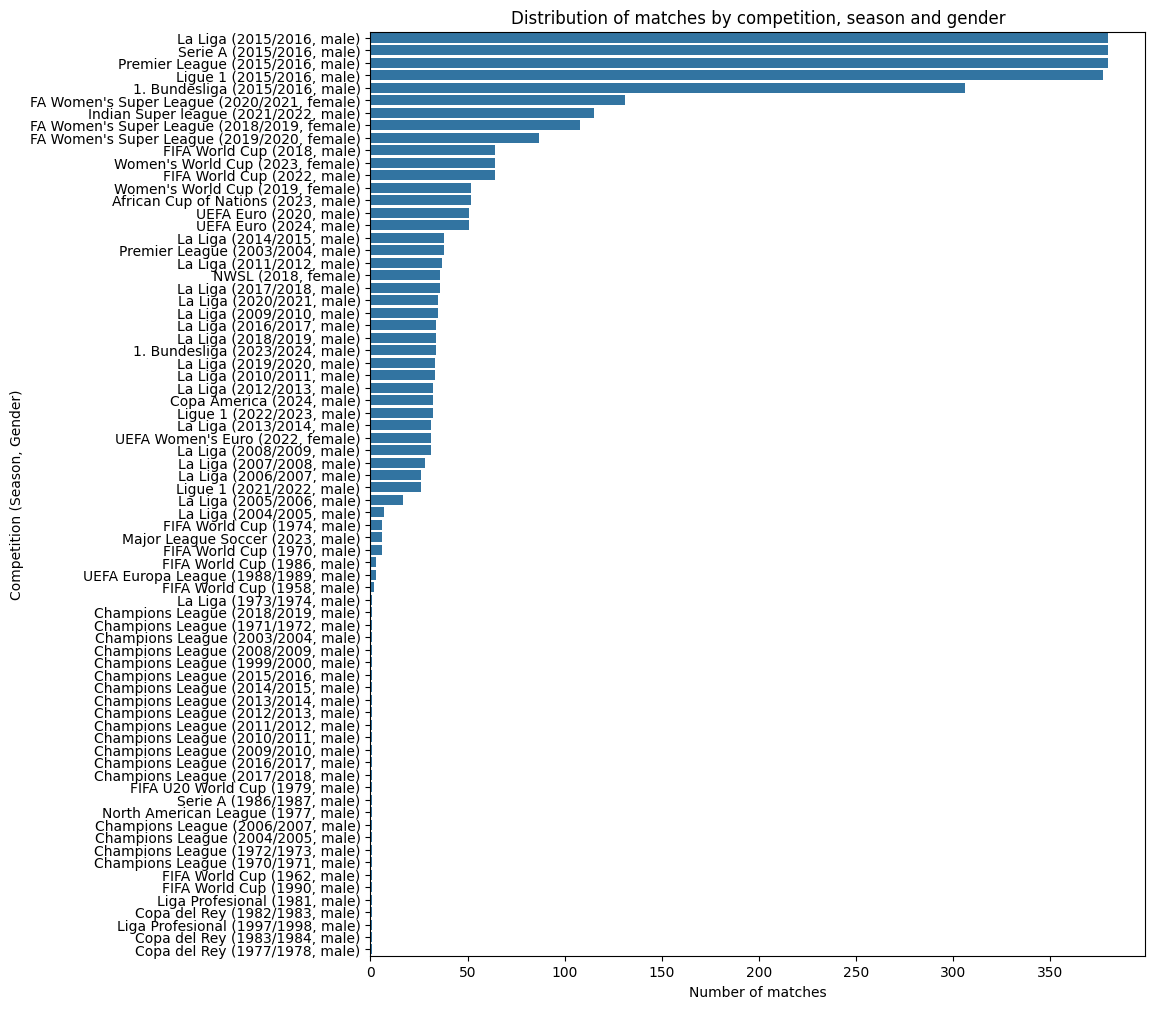

380


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# extraer las columnas necesarias desde las estructuras anidadas
matches_df['competition_name'] = matches_df['competition'].apply(lambda x: x['competition_name'] if isinstance(x, dict) else None)
matches_df['season_name'] = matches_df['season'].apply(lambda x: x['season_name'] if isinstance(x, dict) else None)
matches_df['competition_gender'] = matches_df['home_team'].apply(lambda x: x['home_team_gender'] if isinstance(x, dict) else None)

# crear una columna combinada para identificar cada competición de manera única
matches_df['competition_key'] = matches_df['competition_name'] + ' (' + matches_df['season_name'] + ', ' + matches_df['competition_gender'] + ')'

# crear el gráfico usando la columna combinada
plt.figure(figsize=(10, 12))
sns.countplot(y='competition_key', data=matches_df, order=matches_df['competition_key'].value_counts().index)
plt.title('Distribution of matches by competition, season and gender')
plt.xlabel('Number of matches')
plt.ylabel('Competition (Season, Gender)')
plt.show()

comp = matches_df[matches_df['competition_key'] == 'La Liga (2015/2016, male)']
print(comp.shape[0])

Como podemos observar hay varias competiciones que no tienen todos los datos completos de la temporada y esto se debe a que como bien sabemos las ligas regulares incluyen un total de 380 partidos, la Champions League incluye un total de x partidos, la Copa del Rey incluye un total de x partidos 